# Load Data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import tensorflow_hub as hub

2023-08-22 19:14:56.263554: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 19:14:56.292096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 19:14:57.475361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 32
img_height = 200 
img_width = 200 

In [18]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'DownFER/train', # directory path
    validation_split = None, 
    subset = None, 
    image_size = (img_height, img_width), # image size of height and width
    batch_size = 32# batch size
)

Found 26880 files belonging to 6 classes.


In [19]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'DownFER/test', # directory path
    validation_split = None, 
    subset = None, 
    image_size = (img_height, img_width), # image size of height and width
    batch_size = 32 # batch size
)


Found 7178 files belonging to 7 classes.


In [5]:
class_names = training_ds.class_names
print(class_names)
print(len(class_names))

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
6


In [6]:
# configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# cache() keeps images in memory to ensure dataset does not become a bottleneck 
  # while training the model
# prefetch() overlaps data preprocessing and model execution while training
num_classes = len(class_names)
training_ds = training_ds.cache().prefetch(buffer_size = AUTOTUNE) # for training
testing_ds = testing_ds.cache().prefetch(buffer_size = AUTOTUNE) # for testing

In [21]:
# One-hot encode the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# Apply one-hot encoding to the dataset
training_ds = training_ds.map(one_hot_encode)
testing_ds = testing_ds.map(one_hot_encode)

In [22]:
#set callback to stop training when accuracy reached 85%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>=0.850):
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True
            
            
callbacks = myCallback()

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (224,224) 

def preprocess_image(image,label): 
    image = tf.image.resize(image, target_size) 
    image = preprocess_input(image) 
    return image, label 

In [10]:
import tensorflow as tf
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-08-22 18:36:04.988111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 18:36:04.988301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 18:36:04.988394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("cuDNN Available: ", tf.test.is_built_with_cuda() and tf.test.is_built_with_gpu_support())


Num GPUs Available:  1
CUDA Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDNN Available:  True


In [12]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 224, 224, 3)


2023-08-22 18:36:05.090523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-22 18:36:05.090712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-22 18:36:05.165060: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipe

In [15]:
num_class = 6

In [16]:
def plot_model(model_saved, N, path = None): 
    import matplotlib.pyplot as plt
    import numpy as np
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), model_saved.history['loss'], 
             label = 'training loss') # training loss
    plt.plot(np.arange(0, N), model_saved.history['val_loss'], 
             label = 'test loss') # testing loss
    plt.plot(np.arange(0, N), model_saved.history['accuracy'], 
             label = 'training accuracy') # training accuracy
    plt.plot(np.arange(0, N), model_saved.history['val_accuracy'], 
             label = 'test accuracy') # testing accuracy
    plt.title("Training and Testing Loss and Accuracy") # title of comparative line graph
    plt.xlabel("Epoch #") # x axis label
    plt.ylabel("Loss/Accuracy") # y axis label
    plt.legend(loc = "upper right") # legend

    if path: 
        plt.savefig(path) 

    plt.show()

# EfficientNet B0 to B7 

#### B0

In [17]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

batch_size = 32
img_height = 224
img_width = 224 

inputs = layers.Input(shape=(img_width,img_height,3), batch_size = batch_size) 

#using model without transfer learnaing
outputs = EfficientNetB0(include_top = True, weights = None, classes = num_classes)(inputs) 
eff_wo_tl = tf.keras.Model(inputs,outputs) 
eff_wo_tl.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
eff_wo_tl.summary() 
eff_wo_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 
eff_wo_tl.save('model_weights/effnet_wo_tl.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 224, 224, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/20


2023-08-18 13:15:45.883647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-18 13:15:45.884021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [88080]
	 [[{{node Placeholder/_4}}]]
2023-08-18 13:15:57.486899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-18 13:16:01.507886: I 

2753/2753 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7215

2023-08-18 13:20:18.895226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]
2023-08-18 13:20:18.895604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - 299s 92ms/step - loss: 0.8828 - accuracy: 0.7215 - val_loss: 3.5224 - val_accuracy: 0.2911
Epoch 2/20
2752/2753 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8957
Reached 85% accuracy so cancelling training!
2753/2753 [==============================] - 241s 87ms/step - loss: 0.3104 - accuracy: 0.8957 - val_loss: 3.4648 - val_accuracy: 0.2830


In [26]:
#efficient net b0 with transfer learning from image net
batch_size = 32
img_height = 224
img_width = 224 

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b0_tl = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b0_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b0_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

# Compile
eff_b0_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b0_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b0_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20
2753/2753 [==============================] - 118s 41ms/step - loss: 1.0034 - accuracy: 0.7038 - val_loss: 2.7408 - val_accuracy: 0.2674
Epoch 2/20
2753/2753 [==============================] - 107s 39ms/step - loss: 0.8531 - accuracy: 0.7146 - val_loss: 2.7198 - val_accuracy: 0.2658
Epoch 3/20
2753/2753 [==============================] - 108s 39ms/step - loss: 0.8731 - accuracy: 0.7106 - val_loss: 2.4454 - val_accuracy: 0.3047
Epoch 4/20
2753/2753 [==============================] - 108s 39ms/step - loss: 0.8748 - accuracy: 0.7094 - val_loss: 2.4642 - val_accuracy: 0.2857
Epoch 5/20
2753/2753 [==============================] - 110s 40ms/step - loss: 0.8766 - accuracy: 0.7082 - val_loss: 2.9094 - val_accuracy: 0.2415
Epoch 6/20
2753/2753 [==============================] - 111s 40ms/step - loss: 0.8758 - accuracy: 0.7087 - val_loss: 2.6709 - val_accuracy: 0.2593
Epoch 7/20
2753/2753 [==============================] - 111s 40ms/step - loss: 0.8759 - accuracy: 0.7081 - val_loss: 2

In [45]:
eff_b0_tl.save('model_weights/effnet_b0_tl', save_format = 'tf')

2023-08-18 16:35:53.411277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-18 16:35:53.450203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,96]
	 [[{{node inputs}}]]
2023-08-18 16:35:53.487372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,144]
	 [[{{node inputs}}]]
2023-08-18 16:35:5

INFO:tensorflow:Assets written to: model_weights/effnet_b0_tl/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b0_tl/assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

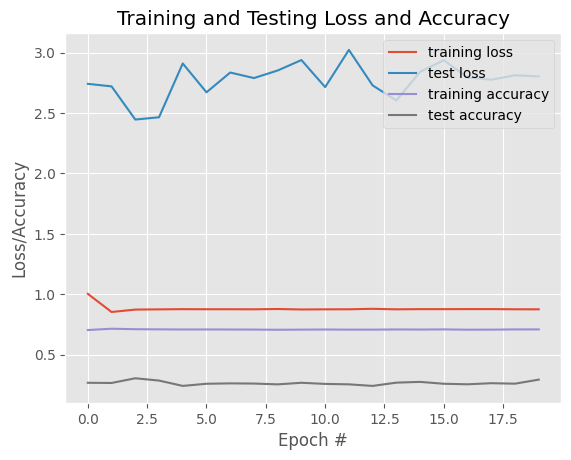

In [44]:
plot_model(model_saved, 'performance_plots/effb0_tl.png')

#### B1 

In [28]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (240,240) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 240, 240, 3)


2023-08-21 11:25:25.821608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 11:25:25.822109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]


In [29]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB1
batch_size = 32
img_height = 240
img_width = 240

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b1_tl = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b1_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b1_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b1_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b1_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b1_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20


2023-08-21 11:25:32.594715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [88080]
	 [[{{node Placeholder/_4}}]]
2023-08-21 11:25:32.594916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.6990

2023-08-21 11:27:30.082507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 11:27:30.082899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]


2753/2753 [==============================] - 154s 55ms/step - loss: 1.0150 - accuracy: 0.6990 - val_loss: 2.9330 - val_accuracy: 0.2074
Epoch 2/20
2753/2753 [==============================] - 150s 55ms/step - loss: 0.8769 - accuracy: 0.7071 - val_loss: 3.1142 - val_accuracy: 0.2246
Epoch 3/20
2753/2753 [==============================] - 152s 55ms/step - loss: 0.8979 - accuracy: 0.6995 - val_loss: 2.6990 - val_accuracy: 0.2270
Epoch 4/20
2753/2753 [==============================] - 147s 53ms/step - loss: 0.8969 - accuracy: 0.6993 - val_loss: 2.6657 - val_accuracy: 0.2412
Epoch 5/20
2753/2753 [==============================] - 151s 55ms/step - loss: 0.8924 - accuracy: 0.7018 - val_loss: 2.7636 - val_accuracy: 0.2633
Epoch 6/20
2753/2753 [==============================] - 149s 54ms/step - loss: 0.8970 - accuracy: 0.7016 - val_loss: 2.6885 - val_accuracy: 0.2646
Epoch 7/20
2753/2753 [==============================] - 150s 54ms/step - loss: 0.8964 - accuracy: 0.7019 - val_loss: 2.3691 - val

In [39]:
tf.saved_model.save(eff_b1_tl, 'model_weights/effnet_b1_tl')

2023-08-21 13:09:58.829079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-21 13:09:58.844498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-08-21 13:09:58.855510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,120,120,16]
	 [[{{node inputs}}]]
2023-08-21 

INFO:tensorflow:Assets written to: model_weights/effnet_b1_tl/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b1_tl/assets


In [37]:
eff_b1_tl

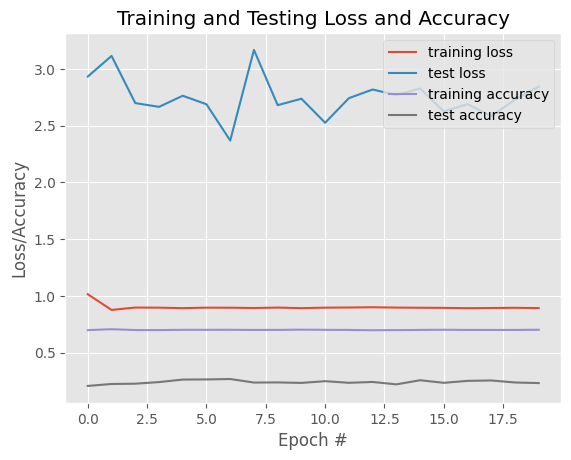

In [35]:
plot_model(model_saved, 20,'performance_plots/effb1_tl.png')

#### B2

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (260,260) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 260, 260, 3)


2023-08-21 13:12:14.610442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 13:12:14.610640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 13:12:14.696753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

In [20]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB2
batch_size = 32
img_height = 260
img_width = 260

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b2_tl = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b2_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b2_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b2_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b2_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b2_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20


2023-08-21 13:12:19.243632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-21 13:12:19.244020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-21 13:12:27.247669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-21 13:12:27.930819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-2

2753/2753 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.6937

2023-08-21 13:14:45.622993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]
2023-08-21 13:14:45.623271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - 194s 67ms/step - loss: 1.0460 - accuracy: 0.6937 - val_loss: 2.6541 - val_accuracy: 0.2929
Epoch 2/20
2753/2753 [==============================] - 180s 65ms/step - loss: 0.8817 - accuracy: 0.7038 - val_loss: 2.7221 - val_accuracy: 0.2759
Epoch 3/20
2753/2753 [==============================] - 179s 65ms/step - loss: 0.8973 - accuracy: 0.6996 - val_loss: 2.7368 - val_accuracy: 0.2637
Epoch 4/20
2753/2753 [==============================] - 176s 64ms/step - loss: 0.9029 - accuracy: 0.6985 - val_loss: 2.6145 - val_accuracy: 0.2597
Epoch 5/20
2753/2753 [==============================] - 175s 63ms/step - loss: 0.9037 - accuracy: 0.6976 - val_loss: 2.7005 - val_accuracy: 0.2668
Epoch 6/20
2753/2753 [==============================] - 178s 65ms/step - loss: 0.9018 - accuracy: 0.6965 - val_loss: 2.6143 - val_accuracy: 0.2453
Epoch 7/20
2753/2753 [==============================] - 179s 65ms/step - loss: 0.9036 - accuracy: 0.6987 - val_loss: 2.6110 - val

In [21]:
tf.saved_model.save(eff_b2_tl, 'model_weights/effnet_b2_tl')

2023-08-21 14:11:49.801550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-08-21 14:11:49.831452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-08-21 14:11:49.852739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,130,130,16]
	 [[{{node inputs}}]]
2023-08-21 

INFO:tensorflow:Assets written to: model_weights/effnet_b2_tl/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b2_tl/assets


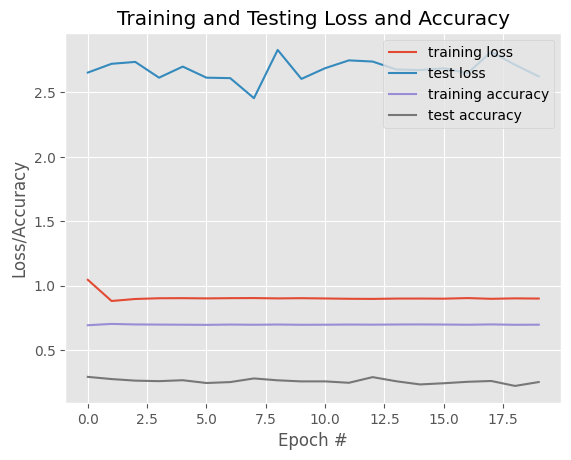

In [22]:
plot_model(model_saved, 20,'performance_plots/effb2_tl.png')

#### B3

In [18]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (300,300) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 300, 300, 3)


2023-08-21 14:40:40.764669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 14:40:40.764870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]
2023-08-21 14:40:40.861700: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pi

In [20]:
#efficient net b1 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB3
batch_size = 32
img_height = 300
img_width = 300

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b3_tl = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b3_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b3_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b3_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b3_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b3_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20


2023-08-21 14:40:47.233153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-21 14:40:47.233532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [88080]
	 [[{{node Placeholder/_4}}]]
2023-08-21 14:40:55.999372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-21 14:40:56.497042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-21

2753/2753 [==============================] - ETA: 0s - loss: 1.0767 - accuracy: 0.6957

2023-08-21 14:44:22.131635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-21 14:44:22.132027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - 282s 99ms/step - loss: 1.0767 - accuracy: 0.6957 - val_loss: 3.3668 - val_accuracy: 0.2209
Epoch 2/20
2753/2753 [==============================] - 258s 94ms/step - loss: 0.8832 - accuracy: 0.7051 - val_loss: 3.3936 - val_accuracy: 0.2239
Epoch 3/20
2753/2753 [==============================] - 257s 93ms/step - loss: 0.9057 - accuracy: 0.6990 - val_loss: 3.4468 - val_accuracy: 0.2137
Epoch 4/20
2753/2753 [==============================] - 255s 93ms/step - loss: 0.9099 - accuracy: 0.6963 - val_loss: 3.3705 - val_accuracy: 0.2336
Epoch 5/20
2753/2753 [==============================] - 256s 93ms/step - loss: 0.9055 - accuracy: 0.7002 - val_loss: 3.6279 - val_accuracy: 0.2003
Epoch 6/20
2753/2753 [==============================] - 257s 93ms/step - loss: 0.9112 - accuracy: 0.6959 - val_loss: 3.2678 - val_accuracy: 0.2213
Epoch 7/20
2753/2753 [==============================] - 259s 94ms/step - loss: 0.9080 - accuracy: 0.6985 - val_loss: 3.6296 - val

In [21]:
tf.saved_model.save(eff_b3_tl, 'model_weights/effnet_b3_tl')

2023-08-21 16:07:36.038548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,40]
	 [[{{node inputs}}]]
2023-08-21 16:07:36.054082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-08-21 16:07:36.065163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,150,24]
	 [[{{node inputs}}]]
2023-08-21 

INFO:tensorflow:Assets written to: model_weights/effnet_b3_tl/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b3_tl/assets


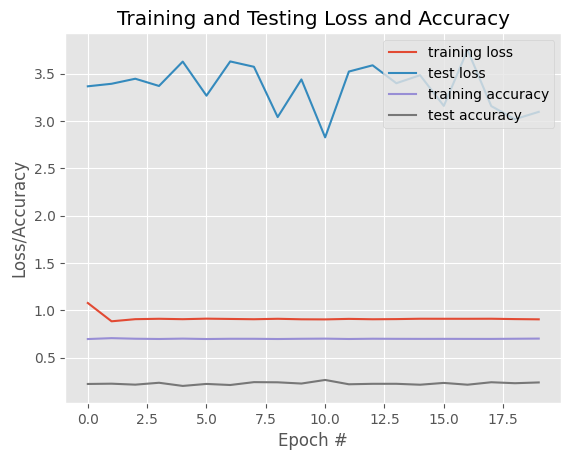

In [24]:
plot_model(model_saved, 20,'performance_plots/effb3_tl.png')

#### B4

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (380,380) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 380, 380, 3)


2023-08-21 21:37:52.445021: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
#efficient net b4 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB4
batch_size = 32
img_height = 380
img_width = 380

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b4_tl = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b4_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b4_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b4_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b4_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b4_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20


2023-08-21 21:38:37.794916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2753/2753 [==============================] - ETA: 0s - loss: 1.1320 - accuracy: 0.6887

2023-08-21 21:54:31.533718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2753/2753 [==============================] - 1316s 477ms/step - loss: 1.1320 - accuracy: 0.6887 - val_loss: 2.4678 - val_accuracy: 0.2602
Epoch 2/20
1441/2753 [==============>...............] - ETA: 7:40 - loss: 0.8772 - accuracy: 0.7083

In [ ]:
tf.saved_model.save(eff_b4_tl, 'model_weights/effnet_b4_tl')

In [ ]:
plot_model(model_saved, 20,'performance_plots/effb4_tl.png')

#### B5

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (456,456) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

Shape of a sample image in training_ds_resized: (32, 456, 456, 3)


2023-08-22 09:52:03.718489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]
2023-08-22 09:52:03.718686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]
2023-08-22 09:52:03.803856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input p

In [25]:
#efficient net b5 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB5
batch_size = 32
img_height = 456
img_width = 456

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b5_tl = EfficientNetB5(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b5_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b5_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b5_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b5_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b5_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

115263384/115263384 [==============================] - 4s 0us/step
Epoch 1/20


2023-08-22 09:52:40.961278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-22 09:52:40.961472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [88080]
	 [[{{node Placeholder/_4}}]]
2023-08-22 09:52:48.662644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-22 09:52:54.561195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22

   1/2753 [..............................] - ETA: 11:11:48 - loss: 2.3413 - accuracy: 0.2188

2023-08-22 09:52:55.435723: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2753/2753 [==============================] - ETA: 0s - loss: 1.1686 - accuracy: 0.7018

2023-08-22 10:03:20.968536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-22 10:03:20.968933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - 852s 304ms/step - loss: 1.1686 - accuracy: 0.7018 - val_loss: 3.3906 - val_accuracy: 0.2287
Epoch 2/20
2753/2753 [==============================] - 831s 302ms/step - loss: 0.8630 - accuracy: 0.7155 - val_loss: 3.3525 - val_accuracy: 0.2486
Epoch 3/20
2753/2753 [==============================] - 835s 303ms/step - loss: 0.8929 - accuracy: 0.7108 - val_loss: 3.3861 - val_accuracy: 0.2550
Epoch 4/20
2753/2753 [==============================] - 841s 305ms/step - loss: 0.8986 - accuracy: 0.7080 - val_loss: 3.2085 - val_accuracy: 0.2473
Epoch 5/20
2753/2753 [==============================] - 828s 301ms/step - loss: 0.9024 - accuracy: 0.7062 - val_loss: 3.4652 - val_accuracy: 0.2471
Epoch 6/20
2753/2753 [==============================] - 822s 299ms/step - loss: 0.8973 - accuracy: 0.7062 - val_loss: 3.4237 - val_accuracy: 0.2402
Epoch 7/20
2753/2753 [==============================] - 830s 302ms/step - loss: 0.9006 - accuracy: 0.7049 - val_loss: 3.636

In [26]:
tf.saved_model.save(eff_b5_tl, 'model_weights/effnet_b5_tl')

2023-08-22 14:29:54.239968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,48]
	 [[{{node inputs}}]]
2023-08-22 14:29:54.256609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-08-22 14:29:54.268791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,228,228,24]
	 [[{{node inputs}}]]
2023-08-22 

INFO:tensorflow:Assets written to: model_weights/effnet_b5_tl/assets


INFO:tensorflow:Assets written to: model_weights/effnet_b5_tl/assets


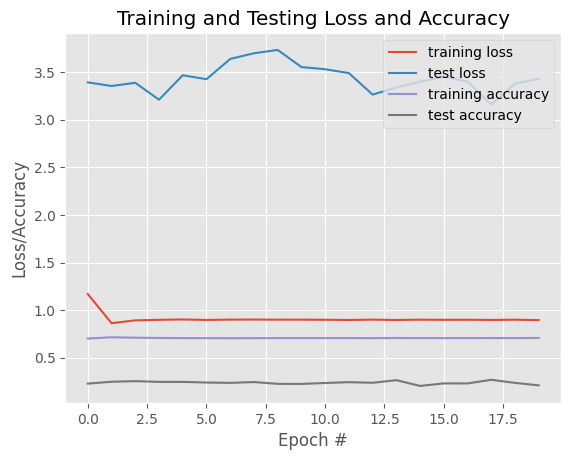

In [27]:
plot_model(model_saved, 20,'performance_plots/effb5_tl.png')

#### B6

In [20]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (528,528) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

2023-08-22 15:45:24.653898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-22 15:45:24.654095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]


Shape of a sample image in training_ds_resized: (32, 528, 528, 3)


2023-08-22 15:45:24.807672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
#efficient net b6 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB6
batch_size = 32
img_height = 528
img_width = 528

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b6_tl = EfficientNetB6(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b6_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b6_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b6_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b6_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b6_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

Epoch 1/20


2023-08-22 15:45:30.619200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-22 15:45:30.619383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [88080]
	 [[{{node Placeholder/_0}}]]
2023-08-22 15:45:44.948489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-22 15:45:45.505925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-2

2753/2753 [==============================] - ETA: 0s - loss: 1.2405 - accuracy: 0.6875

2023-08-22 16:02:44.470191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [31920]
	 [[{{node Placeholder/_4}}]]
2023-08-22 16:02:44.470435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31920]
	 [[{{node Placeholder/_0}}]]


2753/2753 [==============================] - 1397s 502ms/step - loss: 1.2405 - accuracy: 0.6875 - val_loss: 2.4690 - val_accuracy: 0.3003
Epoch 2/20
2753/2753 [==============================] - 1375s 499ms/step - loss: 0.9083 - accuracy: 0.6989 - val_loss: 2.6593 - val_accuracy: 0.2867
Epoch 3/20
2753/2753 [==============================] - 1380s 501ms/step - loss: 0.9389 - accuracy: 0.6914 - val_loss: 2.8721 - val_accuracy: 0.2716
Epoch 4/20
2753/2753 [==============================] - 1371s 498ms/step - loss: 0.9413 - accuracy: 0.6922 - val_loss: 2.7243 - val_accuracy: 0.2694
Epoch 5/20
1007/2753 [=========>....................] - ETA: 10:56 - loss: 0.9445 - accuracy: 0.6924

In [ ]:
tf.saved_model.save(eff_b6_tl, 'model_weights/effnet_b6_tl')

In [ ]:
plot_model(model_saved, 20,'performance_plots/effb6_tl.png')

#### B7

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
target_size =  (600,600) 
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 
sample_image, _ = next(iter(testing_ds_resized.take(1)))
sample_image_shape = sample_image.shape

print("Shape of a sample image in training_ds_resized:", sample_image_shape)

In [ ]:
#efficient net b7 with transfer learning from image net

from tensorflow.keras.applications import EfficientNetB7
batch_size = 32
img_height = 600
img_width = 600

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
eff_b7_tl = EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
eff_b7_tl.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(eff_b7_tl.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(6, activation="softmax", name="pred")(x)

# Compile
eff_b7_tl = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
eff_b7_tl.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_saved=eff_b7_tl.fit(training_ds_resized, validation_data = testing_ds_resized, batch_size = batch_size, epochs = 20, callbacks = [callbacks]) 

In [ ]:
tf.saved_model.save(eff_b7_tl, 'model_weights/effnet_b7_tl')

In [ ]:
plot_model(model_saved, 20,'performance_plots/effb7_tl.png')

# Other baselines - VGGFACE16, RES, MOBILE 

In [23]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
target_size = (200,200)
img_height = 200
img_width = 200
training_ds_resized = training_ds.map(preprocess_image) 
testing_ds_resized = testing_ds.map(preprocess_image) 

### VGG-16

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

inputs = layers.Input(shape=(img_height, img_width, 3))
x = inputs
base = VGG16(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
base.trainable = False

# Build the custom top layers
x = base.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation = 'relu')(x) 
x = Dropout(0.5)(x) 
output = Dense(num_classes, activation = 'softmax')(x) 

# Create the final model
vgg_tl = Model(inputs, output)
vgg_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_saved = vgg_tl.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20, callbacks=callbacks)


Epoch 1/20


2023-08-22 18:37:25.290883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-22 18:37:25.291054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-22 18:37:26.657777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-22 18:37:27.361480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22 

839/840 [============================>.] - ETA: 0s - loss: 1.5208 - accuracy: 0.4201

2023-08-22 18:38:02.958612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]
2023-08-22 18:38:02.958897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7178]
	 [[{{node Placeholder/_0}}]]


840/840 [==============================] - 46s 52ms/step - loss: 1.5208 - accuracy: 0.4202 - val_loss: 1.5311 - val_accuracy: 0.2818
Epoch 2/20
840/840 [==============================] - 43s 51ms/step - loss: 1.2525 - accuracy: 0.4901 - val_loss: 1.5537 - val_accuracy: 0.3096
Epoch 3/20
840/840 [==============================] - 42s 50ms/step - loss: 1.1915 - accuracy: 0.5215 - val_loss: 1.5886 - val_accuracy: 0.3135
Epoch 4/20
840/840 [==============================] - 43s 51ms/step - loss: 1.1498 - accuracy: 0.5370 - val_loss: 1.5584 - val_accuracy: 0.3306
Epoch 5/20
840/840 [==============================] - 43s 51ms/step - loss: 1.1244 - accuracy: 0.5469 - val_loss: 1.6145 - val_accuracy: 0.3231
Epoch 6/20
840/840 [==============================] - 43s 51ms/step - loss: 1.1075 - accuracy: 0.5545 - val_loss: 1.6441 - val_accuracy: 0.3231
Epoch 7/20
840/840 [==============================] - 43s 51ms/step - loss: 1.0875 - accuracy: 0.5610 - val_loss: 1.6546 - val_accuracy: 0.3284
Epo

NameError: name 'model' is not defined

In [21]:
test_loss, test_accuracy = vgg_tl.evaluate(testing_ds_resized)
print("Test accuracy:", test_accuracy)

225/225 [==============================] - 9s 39ms/step - loss: 1.7393 - accuracy: 0.3395
Test accuracy: 0.33950960636138916


In [ ]:
###to be do 


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and compile your model
model = ...  # Define your model here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the EarlyStopping callback
history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=32, epochs=100, callbacks=[early_stopping])

# Access training history
print(history.history)


In [50]:
vgg_tl.save('model_weights/vgg_tl.h5')

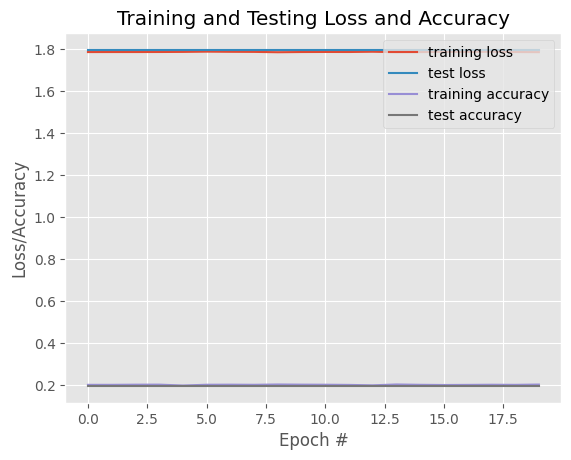

In [53]:
plot_model(model_saved, 'performance_plots/vgg_tl.png')

### Mobile Net

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load and preprocess the data
# (Assuming you've already defined training_ds_resized and testing_ds_resized)

# Define the MobileNetV2 base model
base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')

# Optionally freeze the weights of the base model
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)

output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=32, epochs=100, callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_ds_resized)

# Print test accuracy
print("Test Accuracy:", test_accuracy)


Epoch 1/100
840/840 [==============================] - 22s 24ms/step - loss: 1.7684 - accuracy: 0.3985 - val_loss: 1.6392 - val_accuracy: 0.2680
Epoch 2/100
840/840 [==============================] - 20s 24ms/step - loss: 1.4578 - accuracy: 0.4301 - val_loss: 1.6049 - val_accuracy: 0.2601
Epoch 3/100
840/840 [==============================] - 20s 24ms/step - loss: 1.4281 - accuracy: 0.4369 - val_loss: 1.5953 - val_accuracy: 0.2586
Epoch 4/100
840/840 [==============================] - 20s 23ms/step - loss: 1.4112 - accuracy: 0.4418 - val_loss: 1.6002 - val_accuracy: 0.2608
Epoch 5/100
840/840 [==============================] - 20s 24ms/step - loss: 1.4015 - accuracy: 0.4466 - val_loss: 1.5919 - val_accuracy: 0.2625
Epoch 6/100
840/840 [==============================] - 21s 24ms/step - loss: 1.3931 - accuracy: 0.4501 - val_loss: 1.5929 - val_accuracy: 0.2625
Epoch 7/100
840/840 [==============================] - 20s 24ms/step - loss: 1.3858 - accuracy: 0.4514 - val_loss: 1.5989 - val_ac

In [27]:
mob_tl.save('model_weights/mob_tl.h5')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


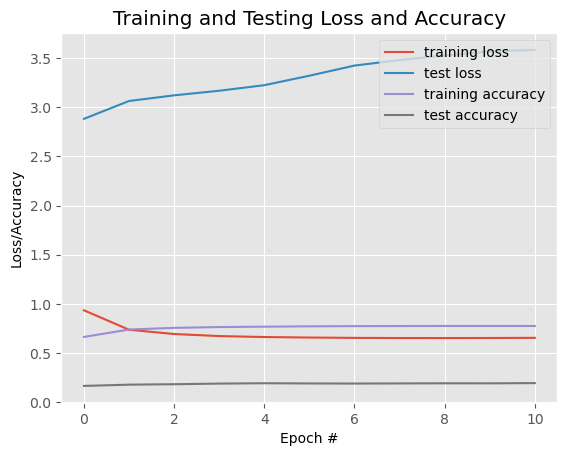

In [36]:
plot_model(history, 11, 'performance_plots/mob_tl.png')

### Custom CNN

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

import tensorflow as tf 

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200,200,3)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(6, activation='softmax'))

# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    training_ds,
    epochs=20,
    validation_data=testing_ds,
    callbacks=[checkpoint_callback]
)

Epoch 1/20


2023-08-22 19:19:19.762156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-22 19:19:19.762340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26880]
	 [[{{node Placeholder/_4}}]]
2023-08-22 19:19:20.464690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-22 19:19:21.489315: I tensorflow/

840/840 [==============================] - ETA: 0s - loss: 1.5521 - accuracy: 0.4081

2023-08-22 19:20:33.923493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]
2023-08-22 19:20:33.923658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7178]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy improved from -inf to 0.31290, saving model to model_weights.h5
840/840 [==============================] - 81s 86ms/step - loss: 1.5521 - accuracy: 0.4081 - val_loss: 1.6725 - val_accuracy: 0.3129
Epoch 2/20
840/840 [==============================] - ETA: 0s - loss: 1.2197 - accuracy: 0.5174
Epoch 2: val_accuracy improved from 0.31290 to 0.35762, saving model to model_weights.h5
840/840 [==============================] - 72s 86ms/step - loss: 1.2197 - accuracy: 0.5174 - val_loss: 1.6043 - val_accuracy: 0.3576
Epoch 3/20
840/840 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.5711
Epoch 3: val_accuracy did not improve from 0.35762
840/840 [==============================] - 72s 86ms/step - loss: 1.0828 - accuracy: 0.5711 - val_loss: 1.8244 - val_accuracy: 0.2028
Epoch 4/20
840/840 [==============================] - ETA: 0s - loss: 1.0087 - accuracy: 0.6045
Epoch 4: val_accuracy improved from 0.35762 to 0.35776, saving model to model_weights.

In [26]:
model.save('model_weights/custom.h5')

### ResNet

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create a baseline ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom top layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(training_ds_resized, validation_data=testing_ds_resized, batch_size=batch_size, epochs=20, callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_ds_resized)
print("Test Accuracy:", test_accuracy)


Epoch 1/20


2023-08-20 20:45:45.990366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2753/2753 [==============================] - ETA: 0s - loss: 43.1341 - accuracy: 0.4256

2023-08-20 20:58:03.921231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2753/2753 [==============================] - 815s 293ms/step - loss: 43.1341 - accuracy: 0.4256 - val_loss: 167.6280 - val_accuracy: 0.3865
Epoch 2/20
2753/2753 [==============================] - 777s 282ms/step - loss: 192.9481 - accuracy: 0.5149 - val_loss: 589.8943 - val_accuracy: 0.1851
Epoch 3/20
2753/2753 [==============================] - 790s 286ms/step - loss: 343.8273 - accuracy: 0.6304 - val_loss: 1441.2035 - val_accuracy: 0.2255
Epoch 4/20
2753/2753 [==============================] - 778s 282ms/step - loss: 478.7492 - accuracy: 0.7050 - val_loss: 2489.1946 - val_accuracy: 0.2588
Epoch 5/20
2753/2753 [==============================] - 786s 285ms/step - loss: 650.9504 - accuracy: 0.7530 - val_loss: 3462.6465 - val_accuracy: 0.2372
Epoch 6/20
2753/2753 [==============================] - 776s 281ms/step - loss: 716.9795 - accuracy: 0.7926 - val_loss: 6300.3433 - val_accuracy: 0.1734
Epoch 7/20
2753/2753 [==============================] - 788s 286ms/step - loss: 852.8113 - accur

In [22]:
model.save('model_weights/res_tl.h5')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


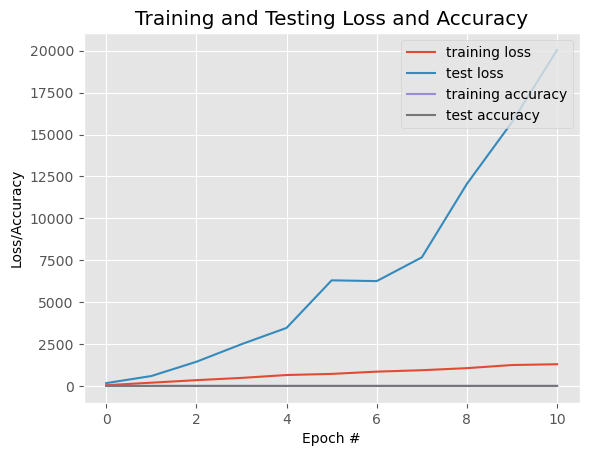

In [24]:
plot_model(history, 11, 'performance_plots/res_tl.png')